In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT='''/content/drive/MyDrive/Colab Notebooks/googledrive/colorDetection'''

Mounted at /content/drive


In [2]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.6 MB/s eta 0:00:00


In [6]:
import json
import matplotlib.pyplot as plt
import numpy as np
from colour import Color
import seaborn as sn
import pandas as pd
from matplotlib.patches import Rectangle

import pingouin as pg
from scipy import stats
import random
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

XIAOROOT='/home/liuxiao/TuringGithub/XiaoData/Rebuttal_Figures/R3.1-Feedback-Zeroshot-eps/Task4-Color/'

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)

    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def ComputeStats_group1(d_cond):
    #compare against chance
    r_data = np.random.choice([0, 1], size=len(d_cond), p=[.5, .5])
    result = pg.ttest(d_cond, r_data, correction=True)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group2(data_d1, data_d2):
    result = pg.ttest(data_d1, data_d2, correction=True)

    # reporting format in Turing project (p < 10−15, two-tailed t-test, t = 8.5, df = 478)
    pval = result.at['T-test',"p-val"]
    Tval = result.at['T-test',"T"]
    dof = math.floor(result.at['T-test',"dof"])
    icon = outputIconForStats(pval)
    return icon, pval, Tval, dof

def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)

    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable]
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group12(pval, Tval, dof):
    if pval < 0.05:
        print('There is difference between data1 and data2.')
        if pval > 0.01 and pval < 0.05:
            print("(p < 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.001 and pval <= 0.01:
            print("(p < 0.01, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        elif pval > 0.0001 and pval <= 0.001:
            print("(p < 0.001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
        else:
            print("(p < 0.0001, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")
    else:
        print('There is NO difference between data1 and data2.')
        print("(p > 0.05, two-tailed t-test, t = " + str("{0:.2f}".format(Tval)) + ", df = " + str(dof) + ")")


def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))


def boostrap(data1, data2):
    import random
    import math
    store = []
    sample_mean = []
    if len(data1) < len(data2):
        SampleTimes = math.ceil(len(data1)/2)
        BootstrapTimes = len(data1)
    else:
        SampleTimes = math.ceil(len(data2)/2)
        BootstrapTimes = len(data2)

    print("bootstraptime",BootstrapTimes,"sampletime",SampleTimes)
    for i in range(BootstrapTimes):
        y1 = random.sample(data1, SampleTimes)
        #print(y1)
        y2 = random.sample(data2, SampleTimes)
        #print(y2)
        y_comb = y1+y2
        #print(y_comb)
        sample_mean.append(np.mean(np.array(y_comb), axis=0))

    stdval = np.std(np.array(sample_mean), axis=0)
    return stdval

def ConcatData(data1, data2):
    import random
    import math

    #print(data1)
    #print(data2)
    if len(data1) < len(data2):
        BootstrapTimes = len(data1)
    else:
        BootstrapTimes = len(data2)

    #print(BootstrapTimes)
    y1 = random.sample(data1, BootstrapTimes)
    #print(y1)
    y2 = random.sample(data2, BootstrapTimes)
    #print(y2)
    y_comb = y1+y2
    y_comb = np.array(y_comb)
    return y_comb


def ComputeBarStdConfMat(contents):
    modelist = ['azure', 'mccq', 'google']
    print(modelist)

    #initialize matrix of absolute counts
    result = {'human':0, 'countH':0, 'machine':0, 'countM': 0, 'result_H':[], 'result_M':[]}
    for modelname in modelist:
        result[modelname] = 0
        result['count_'+modelname] = 0
        result['result_'+modelname]=[]
    #print(result)
#     print(contents)
    # Iterating over keys
    for trialid in contents:

#         print(contents[trialid].keys())
        trialinfor = contents[trialid]['trialData']
        if trialinfor['machine_groundtruth'] == "catch":
            continue
        if trialinfor['groundtruth'] == 'human':
            result['countH'] = result['countH'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['human'] = result['human'] + 1
                result['result_H'].append(1)
            else:
                result['result_H'].append(0)

        else:
            result['countM'] = result['countM'] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result['machine'] = result['machine'] + 1
                result['result_M'].append(1)
            else:
                result['result_M'].append(0)

            modelname = trialinfor['machine_groundtruth'].lower()
            modelname = "mccq" if modelname == "histogram" else modelname

            result['count_'+modelname] = result['count_'+modelname] + 1
            if trialinfor['response_speaker'] == trialinfor['groundtruth']:
                result[modelname] = result[modelname] + 1
                result['result_' + modelname].append(1)
            else:
                result['result_' + modelname].append(0)

    #print(result)
    tmp_ntrials = []
    tmp_str_ntrials = ""
    for _ in result.keys():
      if "count" not in _ or "countH" in _:
        continue
      tmp_str_ntrials += (_.replace('countM','machine (ALL)').replace("count_","") +": "+str(result[_])+"  ")
    print("nTrials:", tmp_str_ntrials)
    #compute confusion matrix
    result_conf_mat = np.zeros((2+len(modelist),2),'float32')
    result_conf_mat[0][0] = result['human']/result['countH']
    result_conf_mat[0][1] = (result['countH'] - result['human'])/result['countH']
    result_conf_mat[1][0] = (result['countM'] - result['machine'])/result['countM']
    result_conf_mat[1][1] = result['machine']/result['countM']

    for i, modelname in enumerate(modelist):
        result_conf_mat[i+2][0] = (result['count_'+modelname] - result[modelname])/result['count_'+modelname]
        result_conf_mat[i+2][1] = result[modelname]/result['count_'+modelname]

    result_conf_mat = np.around(result_conf_mat, decimals=2)

    stdmodelist = ['M', 'azure', 'mccq', 'google']
    modelist_stats = ['Machine', 'Azure', 'MCCQ', 'Google']
    top1 = []
    top1_std = []
    resultFlist = {}
    data1tot = result['result_H']
    for i in range(1+len(modelist)):
        #print(i)
        top1.append((result_conf_mat[0][0]+result_conf_mat[i+1][1])/2)
        # compute bootstrap accuracy
        # compute and save std for top1 accuracy
        top_std_AI = boostrap(result['result_H'], result['result_' + stdmodelist[i]])
        top1_std.append(top_std_AI)
        data2tot = result['result_' + stdmodelist[i]]
        #resultFlist[modelist_stats[i]] = np.concatenate((data1tot,data2tot))
        resultFlist[modelist_stats[i]] = ConcatData(data1tot,data2tot)
    #print(top1)

    return top1, top1_std, result_conf_mat, resultFlist, result


### plots for grouping demographic information
def plot_res_demographics(condition_chosen_list, TextFilePath, plotname,facebarcolor, condition_results):

    compiledAllConds = {}

    modelist = ['Machine', 'Azure', 'MCCQ', 'Google']
    Pdata = {} #data stored for computing statistics
    #initialize PData
    for i in range(0,len(modelist)):
        Pdata[modelist[i]] = {}

    for condition_chosen in condition_chosen_list:
        print(condition_chosen)
        top1, top1std, result_conf_mat, resultFlist = ComputeBarStdConfMat(condition_results[condition_chosen])

        for i in range(0,len(modelist)):
            Pdata[modelist[i]][condition_chosen] = resultFlist[modelist[i]]

#         #compute barplot and errorbar of barplot
#         top1 = []
#         top1std = []

#         #compute confusion matrix
#         result_conf_mat =

        compiledAllConds[condition_chosen] = top1
        compiledAllConds[condition_chosen +'_std'] = top1std

  ### we have the compiled resutls now; lets calculate stats
    chancePval = []
    groupPval = []
    chanceRealPval = []
    groupRealPval = []
    dofs = []

    for i in range(0,len(modelist)):
        for condition_chosen in condition_chosen_list:
            #compute against chance 50%
            d_cond = Pdata[modelist[i]][condition_chosen]
            icon, pval, Tval, dof = ComputeStats_group1(d_cond)
#             chancePval.append(icon)
            chanceRealPval.append(pval)
            dofs.append(dof)
        if len(Pdata[modelist[i]].keys()) == 2:
            data_d1 = Pdata[modelist[i]][condition_chosen_list[0]]
            data_d2 = Pdata[modelist[i]][condition_chosen_list[1]]
            icon, pval, Tval, dof =  ComputeStats_group2(data_d1, data_d2)
            dofs.append(dof)
#             groupPval.append(icon)
            groupRealPval.append(pval)
        elif len(Pdata[modelist[i]].keys()) >= 3:
            icon, BetweenGP_df, WithinGP_df, Fval, pval = ComputeStats_group3(Pdata[modelist[i]])
            groupPval.append(icon)
            groupRealPval.append(pval)
        else:
            print("Oops!  This should NOT happen...")
#     print(chanceRealPval,groupRealPval)

    ### Xiao: R3.7 bonferroni correction
    compiled_pvals = chanceRealPval + groupRealPval
    pvalFlags, correctedPvals, _, alphacBonf = multipletests(compiled_pvals, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False)
    correctedPvals = list(correctedPvals)
    print('Corrected Alpha:',alphacBonf)
    print('Corrected P Values:',correctedPvals)
    print('{} bars from left to right vs Chance:'.format(len(chanceRealPval)),[float(_) for _ in correctedPvals[:len(chanceRealPval)]])
    print('{} group p values from left to right:'.format(len(groupRealPval)),[float(_) for _ in correctedPvals[len(chanceRealPval):]])
    print('dof {} bars from left to right vs Chance :'.format(len(chanceRealPval)),[float(_) for _ in dofs[:len(chanceRealPval)]])
    print('dof {} group from left to right:'.format(len(groupRealPval)),[float(_) for _ in dofs[len(chanceRealPval):]])
    for _ in range(len(chanceRealPval)):
        chancePval.append(outputIconForStats(correctedPvals.pop(0)))

    for _ in range(len(groupRealPval)):
        groupPval.append(outputIconForStats(correctedPvals.pop(0)))
    print(pvalFlags[:len(chanceRealPval)])
    print(chancePval)
    print(pvalFlags[len(chanceRealPval):])
    print(groupPval)

    #data
    #x-axis
    years = list(range(1, len(modelist)))
    strtask = ['Machine (ALL)']+modelist[1:]
    #print(years)
    #print(strtask)

    # Figure Size
    fig, ax = plt.subplots(layout='constrained')
    x = np.arange(len(strtask))  # the label locations
    point_x = [] #for plotting stats * or n.s.

    width = 0.2  # the width of the bars
    if len(condition_chosen_list) == 2:
        multiplier = -0.5 #len(condition_chosen_list)
    else:
        multiplier = -1 #len(condition_chosen_list)
    #ngroups = len(condition_chosen_list)

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist), 0.1,facecolor='yellow'))
    #bar chart properties
    #ax.bar(strtask, top1, color ='black', width = 0.3)

    for ind, condition_chosen in enumerate(condition_chosen_list):
    #for condition_chosen in condition_chosen_list:
    #for attribute, measurement in compiledAllConds.items():
        measurement = compiledAllConds[condition_chosen]
        measurement_std = compiledAllConds[condition_chosen + '_std']
        attribute = {'mturk':'AMT','mturk-feedback':'AMT-Feedback','machine-feedback':'Machine-Feedback','machine-zeroshot':'Machine-Zeroshot'}[condition_chosen]

        offset = width * multiplier

        rects = ax.bar(x + offset, measurement, yerr= measurement_std, width = width,
                       label=attribute, edgecolor='black', color=facebarcolor[ind], ecolor='black')#,
                       #align='center', alpha=0.5, ecolor='black', capsize=10,color ='black')
        #ax.bar_label(rects, padding=3)
        point_x.extend( (x+offset).tolist() )
        multiplier += 1

#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    ########## ready for plotting stats
    #print(point_x)
    ###### getting statistics
    #chancePval, groupPval = getStats(condition_chosen_list, TextFilePath)
    point_x.sort(reverse=False)
    #print(point_x)
    for i, p in enumerate(point_x):
        ax.text(p, .7, chancePval[i], fontsize=8, transform=ax.get_xaxis_transform(),color='blue')

    ax.set_xticks(x, strtask)
    ax.legend(loc='upper left', ncol=1,frameon=False,labelcolor=facebarcolor)
    plt.title('Color detection')
    ###### plot stats for each group of bars
    totalPx = len(point_x)
#     print(totalPx)
#     print(point_x)
    count = 0
    print(groupPval)
    for s1 in range(0,totalPx, len(condition_chosen_list)):
        center_x = 0
        for s2 in range(0,len(condition_chosen_list)):
            center_x = center_x + point_x[s1+s2]
        center_x = center_x/len(condition_chosen_list)
        starting_x = point_x[s1]
        ending_x = point_x[s1+len(condition_chosen_list)-1]
        plt.plot(   np.array([starting_x, ending_x]),
                           np.arange(2)*0+0.82, 'k', label='chance (50%)')
        ax.text(center_x, .8, groupPval[count], fontsize=8, transform=ax.get_xaxis_transform(),color='red')
        count = count + 1

    ###### ending: plot stats for each group of bars

    plt.ylabel('Imitation detectability')
    plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

    plt.ylim(0.25, 1)
    #plt.xlim(0.5, len(years)+0.5)

    #draw chance 0.5
    chancex =np.arange(len(years)+2)-0.5
    plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
    #plt.legend()

    fig.tight_layout()

    fig.set_figwidth(7)
    fig.set_figheight(5)

    #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    # plt.savefig('./plots/'+plotname + '.png',  bbox_inches='tight')
    # plt.savefig('./plots/'+plotname + '.pdf',  bbox_inches='tight')
    # plt.savefig(XIAOROOT+plotname + '.pdf',  bbox_inches='tight')
    # plt.savefig(XIAOROOT+plotname + '.eps', format='eps', bbox_inches='tight')

    plt.show()
#     fig.savefig('../' + plotname + '.png', bbox_inches='tight')
#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.pdf', bbox_inches='tight')

#     fig.savefig('Human_judge_bars_Giorgia'+condition_chosen+'.png', bbox_inches='tight')


# #======================With or without gender questions=======
# with open("./savedResults/compiled.json", 'r') as f:
#     CompiledResults = json.load(f)

# key = 'inlab' #choose from these choices: inlab, mturk
# folderpath = './plots/Task1_' + key + '_' #for saving the plots

# condition_chosen_list = ['inlab_gender','inlab_nogender']
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# plotpathname = './plots/Task1_' + key + '_demor_WwoGenderQuesBarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','darkgrey','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

# #====================== quality controls (mturk versus inlab) =======
# calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
# keep_catch_trials = False

# with open(ROOT +"/Plot/savedResults/compiled_feedback_{}.json".format('rebuttal_allresults'), 'r') as f:
#     CompiledResults = json.load(f)
# # CompiledResults['machine-feedback']

# #====================== (mturk-feedback versus machine-feedback) =======

# key = 'mturk-machine-feedback' #choose from these choices: inlab, mturk
# folderpath = ROOT +'/Plot/plots/Task4_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk-feedback','machine-feedback']
# TextFilePath = ROOT +'/Plot/savedResults/Task4_' + key + '_' #not being used
# plotpathname = 'Task4_' + key + '_rebuttal_BarPlotOverall' #for saving the plots

# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

# #====================== (mturk versus mturk-feedback) =======

# key = 'mturk-muturk-feedback' #choose from these choices: inlab, mturk
# folderpath = ROOT +'/Plot/plots/Task4_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk','mturk-feedback']
# TextFilePath = ROOT +'/Plot/savedResults/Task4_' + key + '_' #not being used
# plotpathname = 'Task4_' + key + '_rebuttal_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)


# #====================== (mturk versus machine-zeroshot) =======

# key = 'mturk-machine-zeroshot' #choose from these choices: inlab, mturk
# folderpath = ROOT +'/Plot/plots/Task4_' + key + '_' #for saving the plots

# condition_chosen_list = ['mturk','machine-zeroshot']
# TextFilePath = ROOT +'/Plot/savedResults/Task4_' + key + '_' #not being used
# plotpathname = 'Task4_' + key + '_rebuttal_BarPlotOverall' #for saving the plots
# facebarcolor = ['dimgray','lightgrey']

# plot_res_demographics(condition_chosen_list, TextFilePath, plotpathname,facebarcolor, CompiledResults)

In [ ]:
len(CompiledResults['mturk-feedback']),len(CompiledResults['machine-feedback'])

(2040, 2000)

['azure', 'mccq', 'google']
bootstraptime 691 sampletime 346
bootstraptime 224 sampletime 112
bootstraptime 249 sampletime 125
bootstraptime 252 sampletime 126


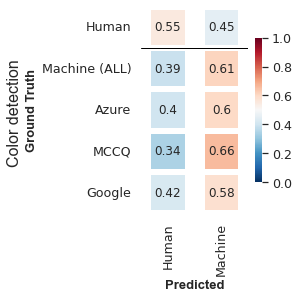

mean
[0.5800000429153442, 0.5750000476837158, 0.6050000190734863, 0.5649999976158142]
std
[0.01324757873721379, 0.027049134524356283, 0.024411318133704948, 0.024875677685787637]
['azure', 'mccq', 'google']
bootstraptime 1175 sampletime 588
bootstraptime 409 sampletime 205
bootstraptime 401 sampletime 201
bootstraptime 365 sampletime 183


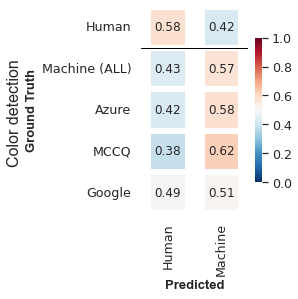

mean
[0.574999988079071, 0.5799999833106995, 0.6000000238418579, 0.5449999570846558]
std
[0.010744436521833666, 0.019167784544267662, 0.02163717477664306, 0.020958738337290613]
['azure', 'mccq', 'google']
bootstraptime 1175 sampletime 588
bootstraptime 409 sampletime 205
bootstraptime 401 sampletime 201
bootstraptime 365 sampletime 183


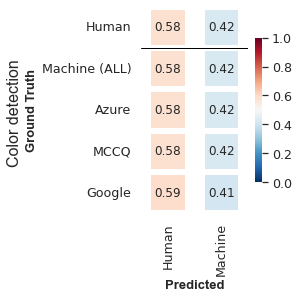

mean
[0.5, 0.5, 0.5, 0.4950000047683716]
std
[0.010817897615356158, 0.01969192559924159, 0.02026546970510425, 0.02139022833745237]
['azure', 'mccq', 'google']
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436


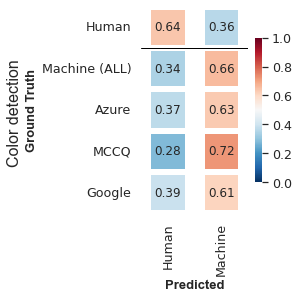

mean
[0.6499999761581421, 0.6349999904632568, 0.6800000071525574, 0.625]
std
[0.01330616194533735, 0.01087880413665702, 0.010734056206417873, 0.01125053540617877]


In [ ]:
import pandas as pd
import os
from matplotlib import font_manager as fm, rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sn.set(font_scale=1.15)
rcParams['font.size'] = 12
fpath_arial = "/home/liuxiao/Downloads/arial/ARIAL.TTF"
fpath_arialbold =  "/home/liuxiao/Downloads/arial/ARIALBD.TTF"
prop_arial = fm.FontProperties(fname=fpath_arial)
prop_arialbold = fm.FontProperties(fname=fpath_arialbold)

def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):

    top1, top1std, result_conf_mat, dummy = ComputeBarStdConfMat(condition_results[condition_chosen])

    modelist = ['Human', 'Machine (ALL)', 'Azure', 'MCCQ', 'Google']
    df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                  columns = [i for i in ['Human','Machine']])
    plt.figure(figsize = (2.4,3.8))

    if condition_chosen == 'machine':
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False,annot_kws={'ha':'center'})#, annot_kws={"fontsize":8})
    else:
#         # change location of colorbar
#         axins = inset_axes(
#         plt.gca(),
#         width="5%",  # width: 5% of parent_bbox width
#         height="50%",  # height: 50%
#         loc="upper left",
#         bbox_to_anchor=(1.05, 0., 1, 1),
#         bbox_transform=plt.gca().transAxes,
#         borderpad=0,
#         )
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=True, annot_kws={'ha':'center'}, cbar_kws={"shrink":0.7})#, "ticks":['0','0.2','0.4','0.6','0.8','1']})#, annot_kws={"fontsize":12})




    for i in range(df_cm.shape[0] + 1):
        ax.axhline(i, color='white', lw=6)
    for i in range(df_cm.shape[1] + 1):
        ax.axvline(i, color='white', lw=20)

    _=ax.axhline(1, color='black', lw=1)
#     print(help(_))
    plt.xlabel("Predicted",weight='bold',fontproperties=prop_arialbold,fontsize=13)
    _ = plt.ylabel("Ground Truth",weight='bold', fontproperties=prop_arialbold,fontsize=13)
    plt.text(-2.5,3.8, "Color detection",fontproperties=prop_arial,fontsize=16,rotation=90)
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90,ha='center')
#     ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, va='center')
#     plt.yticks(range(len(modelist)),modelist, va='center')
#     ax.set_yticks(np.arange(data.shape[0]) + 0.5)





    plotname = condition_chosen
    plt.savefig(folderpath + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.savefig(folderpath + plotname + '_overall_confmat.png', bbox_inches='tight')
    plt.savefig(XIAOROOT + plotname + '_overall_confmat.pdf', bbox_inches='tight')
    plt.savefig(XIAOROOT + plotname + '_overall_confmat.eps', format='eps', bbox_inches='tight')
    plt.show()

    if saveflag == 1:
        np.save(TextFilePath + "confmat.np", result_conf_mat)

    #data
#     #x-axis
#     years = list(range(1, len(modelist)-1))
#     strtask = modelist[1:]
#     #print(years)
#     #print(strtask)

#     # Figure Size
#     fig, ax = plt.subplots()

#     ax.add_patch(Rectangle((-0.5, 0.45), len(modelist)-1, 0.1,facecolor='yellow'))
#     #bar chart properties
#     #ax.bar(strtask, top1, color ='black', width = 0.3)
#     ax.bar(strtask, top1, yerr=top1std,
#        align='center', alpha=0.5, ecolor='black', capsize=10,
#        color ='black', width = 0.3)

    print('mean')
    print(top1)
    print('std')
    print(top1std)

#     plt.ylabel('Top-1 Accuracy')
#     plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees

#     plt.ylim(0.3, 1)
#     #plt.xlim(0.5, len(years)+0.5)

#     #draw chance 0.5
#     chancex =np.arange(len(years)+1)
#     plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#     #plt.legend()

#     fig.tight_layout()

#     fig.set_figwidth(3.5)
#     fig.set_figheight(5)

#     #fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

#     plt.savefig(folderpath + plotname + '_overall_barplot.eps', format='eps', bbox_inches='tight')
#     plt.savefig(folderpath + plotname + '_overall_barplot.png', bbox_inches='tight')
#     plt.savefig(XIAOROOT + plotname + '_overall_barplot.pdf', bbox_inches='tight')

#     plt.show()



#======================Plot overall results (human judges)=======
calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
keep_catch_trials = False
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk' #choose from these choices: inlab, mturk-feedback
TextFilePath = './savedResults/Task4_' + key + '_' #not being used
folderpath = './plots/Task4_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk-feedback' #choose from these choices: inlab, mturk-feedback
TextFilePath = './savedResults/Task4_' + key + '_' #not being used
folderpath = './plots/Task4_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

# #======================Plot overall results (human judges without feedback)=======
# key = 'mturk' #choose from these choices: inlab, mturk
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# folderpath = './plots/Task1_' + key + '_' #for saving the plots
# saveflag = 0 #save confmat for final plots
# plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-feedback' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task4_' + key + '_' #not being used
folderpath = './plots/Task4_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges zeroshot)=======
with open("./savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-zeroshot' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task4_' + key + '_' #not being used
folderpath = './plots/Task4_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

['azure', 'mccq', 'google']
nTrials: machine (ALL): 725  azure: 224  mccq: 249  google: 252  
bootstraptime 691 sampletime 346
bootstraptime 224 sampletime 112
bootstraptime 249 sampletime 125
bootstraptime 252 sampletime 126


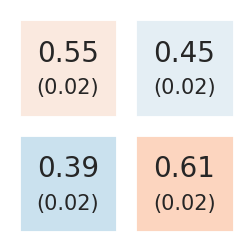

['azure', 'mccq', 'google']
nTrials: machine (ALL): 2616  azure: 872  mccq: 872  google: 872  
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436
bootstraptime 872 sampletime 436
[0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1

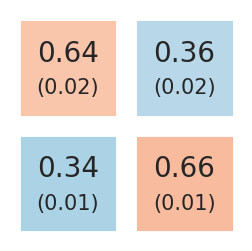

['azure', 'mccq', 'google']
nTrials: machine (ALL): 1175  azure: 409  mccq: 401  google: 365  
bootstraptime 1175 sampletime 588
bootstraptime 409 sampletime 205
bootstraptime 401 sampletime 201
bootstraptime 365 sampletime 183
[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

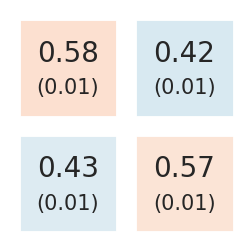

['azure', 'mccq', 'google']
nTrials: machine (ALL): 1175  azure: 409  mccq: 401  google: 365  
bootstraptime 1175 sampletime 588
bootstraptime 409 sampletime 205
bootstraptime 401 sampletime 201
bootstraptime 365 sampletime 183
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

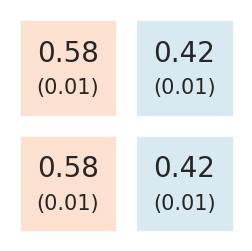

['azure', 'mccq', 'google']
nTrials: machine (ALL): 725  azure: 224  mccq: 249  google: 252  
bootstraptime 691 sampletime 346
bootstraptime 224 sampletime 112
bootstraptime 249 sampletime 125
bootstraptime 252 sampletime 126


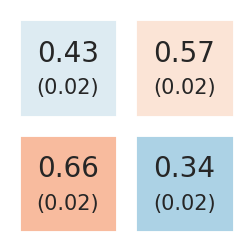

In [11]:
import pandas as pd
import os
from matplotlib import font_manager as fm, rcParams
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sn.set(font_scale=1.15)
rcParams['font.size'] = 20
fpath_arial = "/content/drive/MyDrive/arial/ARIAL.TTF"
fpath_arialbold =  "/content/drive/MyDrive/arial/ARIALBD.TTF"
prop_arial = fm.FontProperties(fname=fpath_arial)
prop_arialbold = fm.FontProperties(fname=fpath_arialbold)

def plot_res_demographics_singleplot(condition_chosen, TextFilePath, condition_results, folderpath, saveflag):
    # XIAO: OVERALL CONFMAT
    if condition_chosen not in ['mturk','machine']:
      top1, top1std, result_conf_mat, dummy, results = ComputeBarStdConfMat(condition_results[condition_chosen])


      print(results['result_M'])
      modelist = ['Human', 'Machine (ALL)']
      df_cm = pd.DataFrame(result_conf_mat[:2], index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      h_std = round(np.std(results['result_H'])/(len(results['result_H'])**0.5),2)
      m_std = round(np.std(results['result_M'])/(len(results['result_M'])**0.5),2)
      stds = np.array([[h_std,h_std],[m_std,m_std]])

    elif condition_chosen == 'mturk':
      top1, top1std, result_conf_mat, dummy, results = ComputeBarStdConfMat(condition_results[condition_chosen])
      modelist = ['Human', 'Machine (ALL)']
      result_conf_mat = np.array([[0.55,0.45],[0.39,0.61]]) # XIAO: OVERALL CONFMAT put original results here
      df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      h_std = round(np.std(results['result_H'])/(len(results['result_H'])**0.5),2)
      m_std = round(np.std(results['result_M'])/(len(results['result_M'])**0.5),2)
      stds = np.array([[h_std,h_std],[m_std,m_std]])
    else:
      top1, top1std, result_conf_mat, dummy, results = ComputeBarStdConfMat(condition_results['mturk'])
      modelist = ['Human', 'Machine (ALL)']
      result_conf_mat = np.array([[0.43,0.57],[0.66,0.34]]) # XIAO: OVERALL CONFMAT put original results here
      df_cm = pd.DataFrame(result_conf_mat, index = [i for i in modelist],
                    columns = [i for i in ['Human','Machine']])
      h_results = [1]*int(0.43*len(results['result_H'])) + [0]*int(0.57*len(results['result_H']))
      m_results = [1]*int(0.66*len(results['result_M'])) + [0]*int(0.37*len(results['result_M']))
      h_std = round(np.std(h_results)/(len(h_results)**0.5),2)
      m_std = round(np.std(m_results)/(len(m_results)**0.5),2)
      stds = np.array([[h_std,h_std],[m_std,m_std]])
    # XIAO: OVERALL CONFMAT END


    plt.figure(figsize = (3,3))
    # text = np.array([ ])
    if condition_chosen == 'machine':
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False,annot_kws={'ha':'center','va':'bottom'})#, annot_kws={"fontsize":8})
    else:
        ax = sn.heatmap(df_cm, annot=True,robust=True, cmap='RdBu_r', vmin=0, vmax=1, cbar=False, annot_kws={'ha':'center','va':'bottom'}, cbar_kws={"shrink":0.7})#, "ticks":['0','0.2','0.4','0.6','0.8','1']})#, annot_kws={"fontsize":12})

    ax.tick_params(left=False, bottom=False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # XIAO: OVERALL CONFMAT
    for i in range(df_cm.shape[0] + 1):
        ax.axhline(i, color='white', lw=15)
    for i in range(df_cm.shape[1] + 1):
        ax.axvline(i, color='white', lw=15)

    voffset = 0.23
    hoffset = -0.27

    for i in range(2):
      for j in range(2):
        plt.text(0.5+j*1+hoffset,0.5+i*1+voffset,'({})'.format(stds[i,j]),fontsize=15)
    # XIAO: OVERALL CONFMAT END

    plotname = condition_chosen

    plt.savefig(ROOT+'/Plot/plots/' + plotname + '_2x2overall.eps', format='eps', bbox_inches='tight')
    plt.savefig(ROOT+'/Plot/plots/' + plotname + '_2x2overall.pdf', bbox_inches='tight')

    plt.show()





#======================Plot overall results (human judges)=======
calculation_type = 'rebuttal_allresults' # exclude training samples when gather human results
keep_catch_trials = False
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)
#======================Plot overall results (human judges)=======
key = 'mturk' #choose from these choices: inlab, mturk-feedback
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges zeroshot)=======
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-zeroshot' #choose from these choices: inlab, mturk
TextFilePath = './savedResults/Task1_' + key + '_' #not being used
folderpath = './plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (human judges with feedback)=======
key = 'mturk-feedback' #choose from these choices: inlab, mturk-feedback
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1 #save confmat for final plots
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

# #======================Plot overall results (human judges without feedback)=======
# key = 'mturk' #choose from these choices: inlab, mturk
# TextFilePath = './savedResults/Task1_' + key + '_' #not being used
# folderpath = './plots/Task1_' + key + '_' #for saving the plots
# saveflag = 0 #save confmat for final plots
# plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open(ROOT+"/Plot/savedResults/compiled_feedback_{}.json".format(calculation_type), 'r') as f:
    CompiledResults = json.load(f)

key = 'machine-feedback' #choose from these choices: inlab, mturk
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)

#======================Plot overall results (AI judges feedback)=======
with open(ROOT+"/Plot/savedResults/compiled.json", 'r') as f:
    CompiledResults = json.load(f)

key = 'machine' #choose from these choices: inlab, mturk
TextFilePath = ROOT+'/Plot/savedResults/Task1_' + key + '_' #not being used
folderpath = ROOT+'/Plot/plots/Task1_' + key + '_' #for saving the plots
saveflag = 1
plot_res_demographics_singleplot(key, TextFilePath, CompiledResults, folderpath, saveflag)



In [9]:
CompiledResults.keys()

dict_keys(['mturk'])